In [207]:
import copy
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import f1_score

from libact.base.dataset import Dataset
from libact.labelers import IdealLabeler
from libact.query_strategies import RandomSampling
from libact.query_strategies.multilabel import MultilabelWithAuxiliaryLearner
from libact.query_strategies.multilabel import MMC, BinaryMinimization
from libact.models.multilabel import BinaryRelevance
from libact.models import LogisticRegression, SVM

np.random.seed(0)

def split_train_test(test_size, num_labelled):
    # choose a dataset with unbalanced class instances
    # calls random sample generators to build artificial datasets
    # data[0] are the examples; data[1] are the labels
    data = make_multilabel_classification(
        n_samples=300, n_classes=10, allow_unlabeled=False)

    # Standardize features by removing the mean and scaling to unit variance
    X = StandardScaler().fit_transform(data[0])
    Y = data[1]
    
    # Split X & Y into random train and test subsets
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=test_size)
    
    # We are giving the Dataset 'num_labelled' fully labelled examples 
    Y_trn_mix = Y_trn[:num_labelled].tolist()+[None]*(len(Y_trn)-num_labelled)
    
    # Dataset is a libact object that stores labelled and unlabelled data 
    # (unlabelled examples are stored as None)
    trn_ds = Dataset(X_trn, Y_trn_mix)
    tst_ds = Dataset(X_tst, Y_tst.tolist())

    fully_labeled_trn_ds = Dataset(X_trn, Y_trn)

    return trn_ds, tst_ds, fully_labeled_trn_ds


def run(trn_ds, tst_ds, lbr, model, qs, quota, fully_labeled_trn_ds):
    C_out, C_out_f1 = [], []

    for _ in range(quota):
        # Query strategy (MMC, BinMin, RandomSampling, 
        # MultilabelWithAuxiliaryLearner) returns id of example to query
        ask_id = qs.make_query()
        
        # Returns the example corresponding to ask_id
        X, _ = trn_ds.data[ask_id]
        
        # Simulated oracle returns the label for the example, x
        lb = lbr.label(X)
        
        # Update training library with new label
        trn_ds.update(ask_id, lb)

        # Train the model (usually Binary Relevance) with the additional label
        model.train(trn_ds)

        # score returns the mean accuracy on the test dataset. In this case we 
        # have chosen to recieve the Hamming loss, which is the fraction of 
        # labels that are incorrectly predicted
        C_out = np.append(C_out, model.score(tst_ds, criterion='hamming'))
        
        C_out_f1 = C_out

    return C_out, C_out_f1


In [208]:
# Multilabel active learning algorithms (query strategies): 
#   1) Binary Minimization (BinMin)
#      Calculates the uncertainty of each label independently
#   2) Maximal Loss Reduction with Maximal Confidence (MMC)
#      Uncertainty based upon the difference between predictions from two 
#      different multilabel classifiers. MMC uses two multilabel classifiers:
#      i) binary relevance 
#      ii) stacked logistic regression
#   3) Multilabel Active Learning With Auxiliary Learner (MLALAL)
#      As with MMC, uncertainty based upon the difference between predictions 
#      from two different multilabel classifiers
#   4) Random Sampling (used as a baseline for comparision)
#   TO DO 5) Adaptive Active Learning (multilabel/adaptive_active_learning.py)

# Query Criteria (i.e. options for evaluating the prediction differences) 
# used for MMC and MLALAL query strategies
# i) Hamming Loss Reduction (HLR)
# ii) Soft Hamming Loss Reduction (SHLR)
# iii) Maximum Margin Reduction (MMR)


trn_ds, tst_ds, fully_labeled_trn_ds = split_train_test(test_size=0.25, num_labelled=5)

trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
trn_ds4 = copy.deepcopy(trn_ds)
trn_ds5 = copy.deepcopy(trn_ds)
trn_ds6 = copy.deepcopy(trn_ds)

# lbr simulates an oracle (method label(x) returns x's label)
lbr = IdealLabeler(fully_labeled_trn_ds)

# This is the model which we train and use for predictions. It divides the task into multiple binary tasks, 
# training one classifier for each label. Unlike OvA and OvR BinaryRelevance does not use one classifier 
# for each possible value for the label
model = BinaryRelevance(LogisticRegression())

quota = 150  # number of samples to query

In [209]:
print "before qs1"
# MMC requires a 'base learner' for its binary relevance (to measure the uncertainty?)
qs = MMC(trn_ds, br_base=LogisticRegression())
E_out_1, E_out_f1_1 = run(trn_ds, tst_ds, lbr, model, qs, quota, fully_labeled_trn_ds)

print "before qs2"

qs2 = RandomSampling(trn_ds2)
E_out_2, E_out_f1_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota, fully_labeled_trn_ds)


print "before qs3"

# Can I replace BinaryRelevance(LogisticRegression()) with model
# MLALAL requires two multilabel models: 
# 1) major_learner, that gives a binary output on each label and is used for final prediction; 
# 2) auxiliary_learner, to estimate the confident on each label, it should give a real value output 
#     (supports pred_real method)

qs3 = MultilabelWithAuxiliaryLearner(
    trn_ds3,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='hlr')
E_out_3, E_out_f1_3 = run(trn_ds3, tst_ds, lbr, model, qs3, quota, fully_labeled_trn_ds)

print "before qs4"

qs4 = MultilabelWithAuxiliaryLearner(
    trn_ds4,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='shlr')
E_out_4, E_out_f1_4 = run(trn_ds4, tst_ds, lbr, model, qs4, quota, fully_labeled_trn_ds)

print "before qs5"

qs5 = MultilabelWithAuxiliaryLearner(
    trn_ds5,
    BinaryRelevance(LogisticRegression()),
    BinaryRelevance(SVM()),
    criterion='mmr')
E_out_5, E_out_f1_5 = run(trn_ds5, tst_ds, lbr, model, qs5, quota, fully_labeled_trn_ds)

print "before qs6"
# BinMin only needs a Continuous Model to eveluate uncertainty
qs6 = BinaryMinimization(trn_ds6, LogisticRegression())
E_out_6, E_out_f1_6 = run(trn_ds6, tst_ds, lbr, model, qs6, quota, fully_labeled_trn_ds)

print "Done qs6"
query_num = np.arange(1, quota + 1)


before qs1
before qs2
before qs3
before qs4
before qs5
before qs6
Done qs6


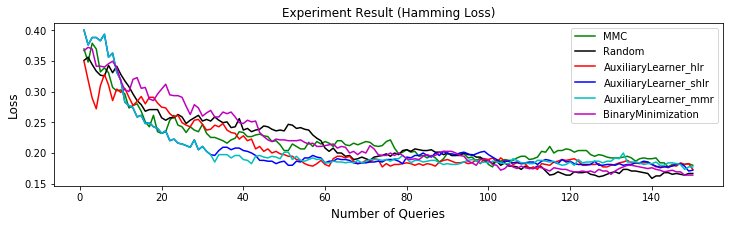

In [245]:
fig = plt.figure(figsize=(12, 3)) # increase plot size
plt.plot(query_num, E_out_1, 'g', label='MMC')
plt.plot(query_num, E_out_2, 'k', label='Random')
plt.plot(query_num, E_out_3, 'r', label='AuxiliaryLearner_hlr')
plt.plot(query_num, E_out_4, 'b', label='AuxiliaryLearner_shlr')
plt.plot(query_num, E_out_5, 'c', label='AuxiliaryLearner_mmr')
plt.plot(query_num, E_out_6, 'm', label='BinaryMinimization')

plt.title('Experiment Result (Hamming Loss)', fontsize=12)
plt.xlabel('Number of Queries', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [247]:
# Useful code to generate other types of learning curves

# new_X, _ = trn_ds2.format_sklearn
# print new_X.shape

print type(trn_ds2.data)

X, y =  trn_ds2.format_sklearn()

print X.shape, y.shape # (155, 20) (155, 10)

# model.score(tst_ds)


<type 'list'>
(155, 20) (155, 10)
